<a href="https://colab.research.google.com/github/tamzid1984/DeepLearning/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
import sys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import string
import nltk
from nltk import PorterStemmer
import re
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')
from gensim import corpora
import gensim
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
    print("GPU device-name is:", device_name)
print('Found GPU at: {}'.format(device_name))
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import math 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data Visualizations
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


GPU device-name is: /device:GPU:0
Found GPU at: /device:GPU:0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_fake = pd.read_csv('drive/MyDrive/Fake_Real/Fake.csv')
df_real = pd.read_csv('drive/MyDrive/Fake_Real/True.csv')

df_fake['category'] = 1
df_real['category'] = 0

df = pd.concat([df_fake, df_real])

In [ ]:
# df_fake.value_counts

In [ ]:
# df_real.value_counts()

In [ ]:
# df

In [4]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# df

In [5]:
df.isnull().sum().sum()

0

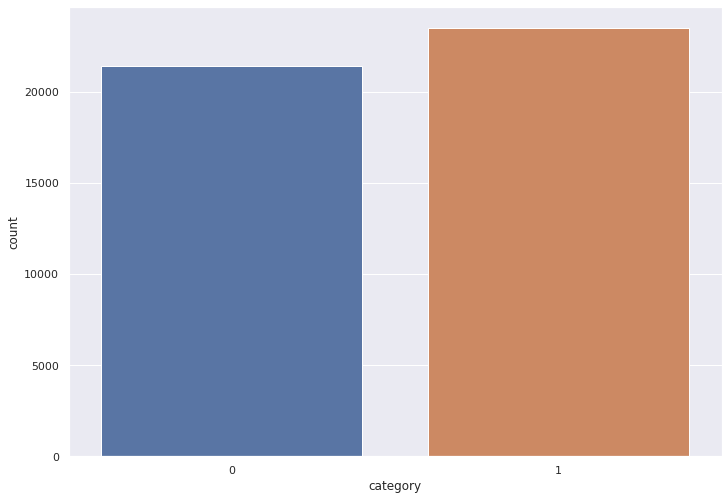

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(df['category'])

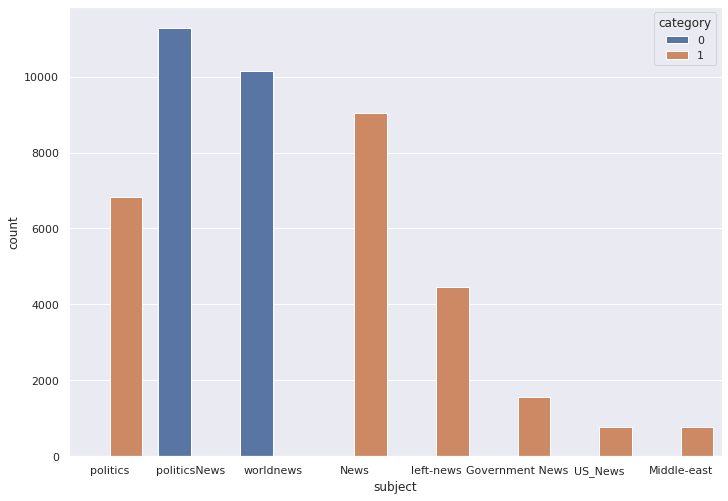

In [7]:
sns.countplot(df['subject'], hue=df['category'])

In [8]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [12]:
#!pip install transformers

In [11]:
from transformers import BertTokenizer
from tqdm import tqdm

#importing BERT and Loading the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
df_update = df.drop('category', axis =1)
y = df.category

In [14]:
y.value_counts()

1    23481
0    21417
Name: category, dtype: int64

In [15]:
df_train, df_test, y_train, y_test = train_test_split(df_update, y, random_state = 42, test_size=0.20, stratify = y)

In [16]:
y_train

28261    0
14938    0
29333    0
17986    1
2958     0
        ..
22378    0
22584    0
5338     0
34085    0
2410     1
Name: category, Length: 35918, dtype: int64

In [17]:
df_train['final'] = df_train['title'] 

In [18]:
statements = df_train['final']

In [19]:
from transformers import  BertTokenizer
from torch.utils.data import Dataset, TensorDataset
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
bert_input_ids = []
bert_attention_masks = []
roberta_input_ids = []
roberta_attention_masks = []
sentence_ids = []
counter = 0

# For every sentence...
for sent in statements:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    bert_encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    sentence_ids.append(counter)
    counter  = counter + 1


bert_input_ids = torch.cat(bert_input_ids, dim=0)
bert_attention_masks = torch.cat(bert_attention_masks, dim=0)
labels = torch.tensor(y_train.values) 
sentence_ids = torch.tensor(sentence_ids)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# print(bert_input_ids)
# print("\n")
# print(bert_attention_masks)
# print("\n")
# print(roberta_input_ids)
# print("\n")
# print(roberta_attention_masks)
# print("\n")
# print(sentence_ids)
# print("\n")

In [20]:
bert_dataset = TensorDataset(bert_input_ids, bert_attention_masks, labels)

In [ ]:
# print(bert_dataset())

In [21]:
len(bert_dataset)

35918

In [22]:
train_size = int(0.5 * len(bert_dataset))
val_size = len(bert_dataset) - train_size

# Divide the dataset by randomly selecting samples.
bert_train_dataset, bert_val_dataset = torch.utils.data.random_split(bert_dataset, [train_size, val_size])

In [23]:
val_size

17959

In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 7


bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


# For validation the order doesn't matter, so we'll just read them sequentially.
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [25]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [26]:
bert_optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [27]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 2,I have already seen that the model starts overfitting beyound 2 epochs
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(bert_train_dataloader) * epochs

# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [28]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [30]:
device = "cuda:0"
model = model.to(device)

In [31]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
val_loss =[]
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        bert_optimizer.step()

        # Update the learning rate.
        bert_scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(bert_train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

        eval_loss += loss.item()

    avg_valid_loss = (eval_loss/nb_eval_steps)
    val_loss.append(avg_valid_loss)
    # Report the final accuracy for this validation run.
    print("Loss: {0:.2f}".format(eval_loss/len(bert_validation_dataloader)))
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  2,566.    Elapsed: 0:00:19.
  Batch   200  of  2,566.    Elapsed: 0:00:37.
  Batch   300  of  2,566.    Elapsed: 0:00:54.
  Batch   400  of  2,566.    Elapsed: 0:01:11.
  Batch   500  of  2,566.    Elapsed: 0:01:29.
  Batch   600  of  2,566.    Elapsed: 0:01:47.
  Batch   700  of  2,566.    Elapsed: 0:02:05.
  Batch   800  of  2,566.    Elapsed: 0:02:23.
  Batch   900  of  2,566.    Elapsed: 0:02:41.
  Batch 1,000  of  2,566.    Elapsed: 0:02:59.
  Batch 1,100  of  2,566.    Elapsed: 0:03:17.
  Batch 1,200  of  2,566.    Elapsed: 0:03:35.
  Batch 1,300  of  2,566.    Elapsed: 0:03:54.
  Batch 1,400  of  2,566.    Elapsed: 0:04:12.
  Batch 1,500  of  2,566.    Elapsed: 0:04:30.
  Batch 1,600  of  2,566.    Elapsed: 0:04:49.
  Batch 1,700  of  2,566.    Elapsed: 0:05:07.
  Batch 1,800  of  2,566.    Elapsed: 0:05:25.
  Batch 1,900  of  2,566.    Elapsed: 0:05:44.
  Batch 2,000  of  2,566.    Elapsed: 0:06:02.
  Batch 2,100  of

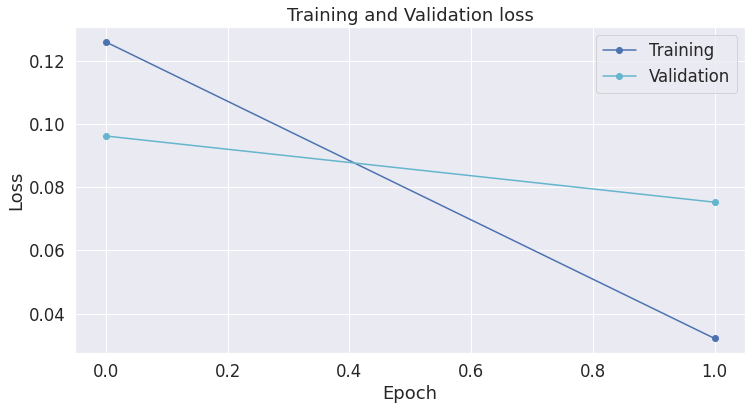

In [33]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')
plt.plot(val_loss, 'c-o')

# Label the plot.
plt.title("Training and Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.gca().legend(('Training','Validation'))

plt.show()

In [34]:
df_test

,title,text,subject,date
4467,Germany’s Merkel And France’s Hollande Get Ham...,Marine Le Pen tells off the two leaders who ve...,politics,"Oct 20, 2015"
10485,U.S. must stop judicial 'extortion' of corpora...,PARIS (Reuters) - Europe should challenge the ...,politicsNews,"October 11, 2016"
36414,"Disclose your donors, South African court tell...",JOHANNESBURG (Reuters) - South Africa s politi...,worldnews,"September 27, 2017"
31865,"As North Korea girds for latest sanctions, eco...","DANDONG, China (Reuters) - The United Nations ...",worldnews,"September 13, 2017"
74,CHAOS AND MOB RULE at Charlottesville City Cou...,This is mob rule AGAIN! The best part of this ...,politics,"Aug 22, 2017"
...,...,...,...,...
7393,"Just 10 Days Before The Orlando Shooting, Pre...",Here s what we know about the Orlando shooter:...,News,"June 13, 2016"
22639,Good Lord! Government Workers Are Way Out Of B...,Thanks to the CATO Institute we know for sure ...,Government News,"Oct 8, 2015"
35682,The NY Daily News Has Just LITERALLY Told Ted...,"If there s one thing you never do in life, it ...",News,"January 15, 2016"
12149,SHOCKING NEW MOVIE Shows How Easily Islamic Te...,Dennis Michael Lynch has made some shocking an...,Government News,"Jan 1, 2016"


In [35]:
df_test.isnull().sum().sum()

0

In [36]:
df_test['final'] = df_test['title']  

In [37]:
test_statements = df_test['final']

In [38]:
test_comments = y_test

In [39]:
test_comments.values


array([1, 0, 0, ..., 1, 1, 0])

In [41]:
# We'll borrow the `pad_sequences` utility function to do this.
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
# Set the required sequence length.
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
bert_input_ids = pad_sequences(bert_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0

Done.


In [42]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sen in test_statements:
    
    # Report progress.
    if ((len(bert_input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(bert_input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,          # Truncate all sentences.                        
                   )
    
    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_sent)

print('DONE.')
print('')
print('{:>10,} test comments'.format(len(test_input_ids)))

# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
#test_labels = df_test.attack.to_numpy().astype(int)

print('{:>10,} positive (contains attack)'.format(np.sum(test_comments)))
print('{:>10,} negative (not an attack)'.format(len(test_comments) - np.sum(test_comments)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                               dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_comments.values)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

DONE.

     8,980 test comments
     4,696 positive (contains attack)
     4,284 negative (not an attack)


In [43]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 8,980 test sentences...
  Batch   100  of    281.    Elapsed: 0:00:21.
  Batch   200  of    281.    Elapsed: 0:00:43.
    DONE.


In [44]:
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [45]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# Use the model output for label 1 as our predictions.
p1 = predictions[:,1]

# Calculate the ROC AUC.
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.999


Text(0, 0.5, 'True Positive Rate')

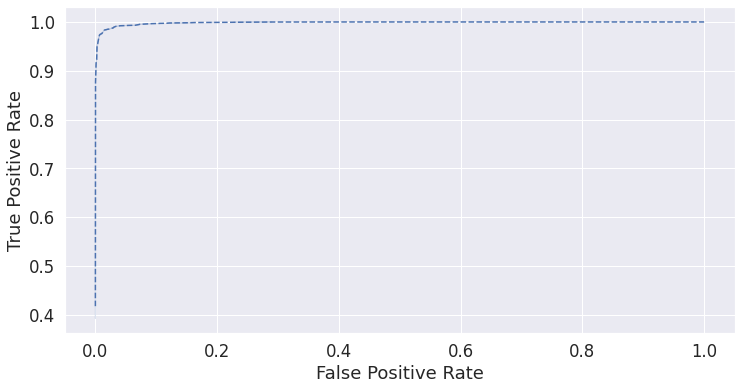

In [46]:
fpr, tpr, _ = metrics.roc_curve(true_labels, p1)
sns.lineplot(fpr, tpr, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [47]:
predictions = np.argmax(predictions, axis=1).flatten()

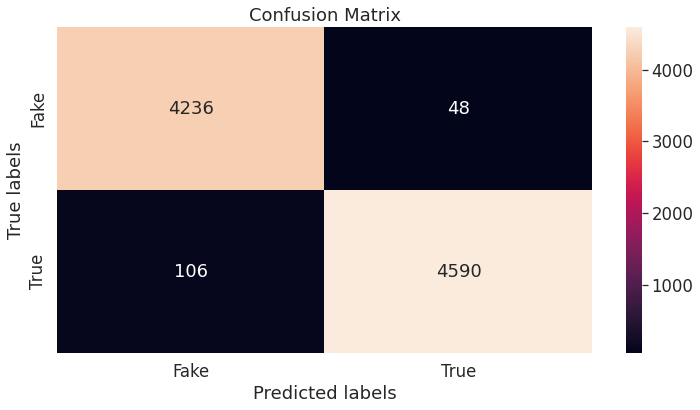

In [48]:
mat = confusion_matrix(true_labels, predictions)
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fake', 'True']); ax.yaxis.set_ticklabels(['Fake', 'True']);

In [49]:
print(classification_report(true_labels,predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4284
           1       0.99      0.98      0.98      4696

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

